# Params #  
X -> m-by-n matrix of net returns (samples-by-assets)  
r -> m-dimensional vec of net returns of index  
reg -> sparsity regularization parameter  
u -> upper bound of weights  
w_0 -> initial point  
p_neg_exp -> final negative exponent of p  
max_iter -> max number of iterations  

return n-dimensional vector w/ allocation weights on the assets  

In [119]:
# TODO: Consider hw to improve sparsity in portfolio cardinality
# TODO: Clean up debug print statements
# TODO: Discuss potential drawbacks (if S&P performs terribly then it will be reflected, which happened in the 2022-01-01 to 2023-01-01 timeframe); Weird bug with 2023-03-01 and onwards, also with 2020-01-01, not sure what the issue is; might be smth to do with inc/exc bounds
# TODO: Look into HUBER tracking errors for beating the S&P
# TODO: Add support for other indices besides S&P (maybe just simple if-else switches or passing supported index parameters)

In [120]:
import torch
import math
from sec import stock, constants, lookups
from polygon import RESTClient
import yfinance as yf # temporary until we figure out polygon api
import scipy
import numpy as np
import pandas as pd

In [121]:
constants.set_polygon_key("_4BtZn3PRCLu6fsdu7dgddb4ucmB1sfp")
poly_cli = RESTClient(api_key="_4BtZn3PRCLu6fsdu7dgddb4ucmB1sfp")
torch.set_default_dtype(torch.float64)

In [122]:
curr_sp = lookups.get_sp500_tickers()
print(len(curr_sp))
print(curr_sp)

503
['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BG', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DL

In [123]:
# aggregate all close data (has been modularized below)
# TODO: remove later after backtesting
# close_data = torch.zeros((252, len(curr_sp)))

# for i in range(len(curr_sp)):
#     aggs = []
#     data = poly_cli.list_aggs(ticker=curr_sp[i], multiplier=1, timespan="day", from_="2023-02-01", to = "2024-02-01")
#     for j, agg in enumerate(data):
#         close_data[j, i] = agg.close

# print(close_data)

In [124]:
# torch.set_default_dtype(torch.float64)

# col_dim = close_data.shape[0]
# return_data = torch.zeros((252, len(curr_sp)))
# for i in range(1, col_dim):
#     return_data[i] = (close_data[i, :] - close_data[0, :])/close_data[0, :]
# print(return_data)

In [1]:
# @param start -> "YYYY-MM-DD"
# source: https://www.tradinghours.com/publications/trading-days-per-year
# unsure of source accuracy
def getTradingDays(start):
    year = start[0:4]

    # hardcode trading days per year
    tradingDays = {
        2023: 252,
        2022: 252,
        2021: 252,
        2020: 253,
        2019: 252,
        2018: 251,
        2017: 251,
        2016: 252,
        2015: 252,
        2014: 252,
        2013: 252,
        2012: 250,
        2011: 252,
        2010: 252
    }

    return tradingDays.get(year, 252)

In [3]:
# @param start -> "YYYY-MM-DD"
# calculates
def getCloseData(start):
    curr_sp = lookups.get_sp500_tickers()
    close_data = torch.zeros((getTradingDays(start), len(curr_sp)))

    end = str(int(start[0:4]) + 1) + start[4:]

    for i in range(len(curr_sp)):
        # aggs = []
        data = poly_cli.list_aggs(ticker=curr_sp[i], multiplier=1, timespan="day", from_=start, to = end)
        for j, agg in enumerate(data):
            close_data[j, i] = agg.close
    return close_data

# close = getCloseData("2023-02-01")

In [126]:
# curr_sp is current s&p tickers
# method simply retrieves close of certain ticker we specify
def getTickerClose(ticker, curr_sp, close_data):
    ix = curr_sp.index(ticker)
    print(close_data[:, ix])

# getTickerClose("AAPL", curr_sp, close_data)

In [4]:
def calculateTickerReturns(start):
    close_data = getCloseData(start)
    col_dim = close_data.shape[0]
    return_data = torch.zeros((getTradingDays(start), len(curr_sp)))
    for i in range(1, col_dim):
        return_data[i] = (close_data[i, :] - close_data[0, :])/close_data[0, :]
    return return_data

In [128]:
def collectSP500(start):
    index_symbol = "^GSPC"
    end = str(int(start[0:4]) + 1) + start[4:]
    index_data = yf.download(index_symbol, start=start, end=end, interval="1d")
    index_close_data = torch.tensor(index_data["Close"].values)
    return index_close_data

In [5]:
def calculateIndexReturns(start):
    index_data = collectSP500(start)
    dim = index_data.shape[0]
    return_data = torch.zeros(getTradingDays(start))
    for i in range(1, dim):
        return_data[i] = ((index_data[i] - index_data[0])) / index_data[0]
    return return_data.reshape(getTradingDays(start), 1)

In [130]:
def preparePipeline(start):
    ticker_returns = calculateTickerReturns(start)
    index_returns = calculateIndexReturns(start)
    return ticker_returns, index_returns
# test, test2 = preparePipeline("2023-03d-02")

# Algorithm #

In [131]:
# funcition to solve kkt
def bisection(c, u):
  n = len(c)
  w = torch.zeros(n) # new weight vector
  c_sort, sort_indices = torch.sort(c)
  
  high = n - 1
  low = 0

  while low <= high:
    mid = (low + high) // 2
    if mid == 0:
      break
    mu = -1/mid * (torch.sum(c_sort[0:mid]) + 2)

    cond1 = (mu + c_sort[mid] < 0).item()

    if mid < n:
      cond2 = torch.all((mu + c_sort[mid] >= 0)).item()
    else:
      cond2 = True

    if cond1 and cond2:
      break
    elif cond1 and not cond2:
      low = mid + 1
    else:
      high = mid - 1

  new_values = -(mu + c_sort[:mid] / 2)
  if torch.all(-(mu + c_sort[:mid])/2 <= u).item():
      # print(f"This is w.shape in bisection: {w.shape}")
      # print(f"This is what is getting put in w in bisecttion: {(-(mu + c_sort[:mid])/2).shape}")
      w[sort_indices[:mid]] = -(mu + c_sort[:mid])/2
      # print("We get to the if and this is executed")
      # print(w)
      # print(w.shape)
      return w
  else:
    flag = False
    flag2 = False
    k = mid

    while True:
      low1 = 0
      high1 = k - 1

      while low1 <= high1:
        mid1 = (low1 + high1) // 2
        mu = (2 * mid1 * u - torch.sum(c_sort[mid1:k]) - 2) / (k - mid1)

        if mid1 != 0:
          cond1 = torch.all((mu + c_sort[mid1] <= -2*u)).item()
        else:
          cond1 = True

        cond2 = torch.all(((-2 * u) < (mu + c_sort[mid1]))).item() and torch.all(((mu + c_sort[k - 1]) < 0)).item()

        if k < n:
          cond3 = torch.all((mu + c_sort[k]) >= 0).item()
        else:
          cond3 = True

        if cond1 and cond2 and cond3:
          flag = True
          break
        elif cond1 and not cond2:
          low1 = mid1 + 1
        else:
          high1 = mid1 - 1

      if flag:
        break
      else:
        k = k + 1

      if k > n:
        flag2 = True
        break

    if flag2:
      num_elements = int(torch.ceil(torch.tensor(1/u)))
      w[sort_indices[:num_elements]] = u
    else:
      w[sort_indices[:mid1]] = u
      w[sort_indices[mid1:k]] = -(mu + c_sort[mid1:k]) / 2
    print("we got to this new territory")
    return w

In [132]:
# import torch

# def bisection(c, u):
#     n = len(c)
#     w = torch.zeros(n).reshape(503, 1)
#     c_sort, sort_indices = torch.sort(c)

#     high = n - 1
#     low = 0

#     while low <= high:
#         mid = (low + high) // 2
#         mu = -1/mid * (torch.sum(c_sort[:mid]) + 2)
#         print(mu)

#         tst1 = (mu + c_sort[mid - 1] < 0).item()
#         tst2 = (mu + c_sort[mid] >= 0).item() if mid < n else True

#         if tst1 and tst2:
#             break
#         elif tst1 and not tst2:
#             low = mid + 1
#         else:
#             high = mid - 1

#     if torch.all(-(mu + c_sort[:mid])/2 <= u):
#         print(w)
#         print(-(mu + c_sort[:mid])/2)
#         w[sort_indices[:mid]] = -(mu + c_sort[:mid])/2
#         print("Entered the if loop and this is w")
#         print(w)
#         return w
#     else:
#         flg = False
#         flg2 = False
#         k = mid

#         while True:
#             low1 = 0
#             high1 = k - 1

#             while low1 <= high1:
#                 mid1 = (low1 + high1) // 2
#                 if k - mid1 == 0:
#                     break
#                 mu = (2*mid1*u - torch.sum(c_sort[mid1:k]) - 2) / (k - mid1)

#                 tst1 = (mu + c_sort[mid1 - 1] <= -2*u).item() if mid1 != 0 else True
#                 tst2 = ((-2*u) < (mu + c_sort[mid1])).item() and ((mu + c_sort[k - 1]) < 0).item()

#                 tst3 = (mu + c_sort[k] >= 0).item() if k < n - 1 else True

#                 if tst1 and tst2 and tst3:
#                     flg = True
#                     break
#                 elif tst1 and not tst2:
#                     low1 = mid1 + 1
#                 else:
#                     high1 = mid1 - 1

#             if flg:
#                 break
#             else:
#                 k += 1

#             if k > n:
#                 flg2 = True
#                 break

#         if flg2:
#             num_elements = int(torch.ceil(1/u))
#             w[sort_indices[:num_elements]] = u
#         else:
#             w[sort_indices[:mid1]] = u
#             w[sort_indices[mid1:k]] = -(mu + c_sort[mid1:k])/2

#         return w


In [133]:
# increasing the weight
def eteMMupdate(w, B, b, Lmax_A, reg, p , c_1, u):
  # print(f"w: {w}")
  # print(f"B: {B}")
  # print(f"b: {b}")
  # print(f"Lmax_A: {Lmax_A}")
  # print(f"reg: {reg}")
  # print(f"p: {p}")
  # print(f"c_1: {c_1}")
  # print(f"u: {u}")
  d = reg / ((p + abs(w)) * c_1)
  # print(f"d: {d}")
  c = B @ w + 1/Lmax_A * (b + d) # calculation for q_ete, tracking error, 503 x 503 @ 503 x 1 + 
  
  # print(f"This is c.shape {c.shape}")
  c = c.reshape(503)
  # print(f"This is c after reshape in eteMMupdate {c.shape}")
  # print(f"c: {c}")

  return bisection(c,u)

In [134]:
def track(data, returns, reg, thres = 1e-6, u = 1, w_0 = None, p_neg_exp = 7, max_iter = 1000):
  X = data.double()

  nan_count = torch.isnan(X).sum().item()
  print(f"Number of NaNs in the original matrix: {nan_count}")

  # cleaning up NaN
  def fill_with_rolling_mean(series, window_size=10):
    temp_series = series.copy()
    rolling_means = temp_series.rolling(window_size, min_periods=1, center=True).mean()
    return series.fillna(rolling_means)
  
  X_df = pd.DataFrame(X.numpy())
  X_df_filled = X_df.apply(fill_with_rolling_mean, axis=1)
  # print(X_df_filled.shape)

  # nan_count = X_df_filled.isna().sum().sum()
  # print(f"Number of NaNs in the X_df_filled matrix: {nan_count}")

  X_df.where(pd.notna(X_df), X_df_filled, inplace=True)
  # print(X_df.shape)
  X = torch.tensor(X_df.to_numpy())
  # nan_count = torch.isnan(X).sum().item()
  # print(f"Number of NaNs in the cleaned matrix: {nan_count}")

  n = X.shape[1] # assets
  m = X.shape[0] # time

  if n == 1:
    print("Must track more than one asset")

  
  w_0 = (torch.ones(n) / n).reshape(503,1) # w_0 ~ Normal
  # print(w_0)
  # print(f"This is {w_0.shape}")

  F_v = torch.zeros((max_iter, 1))

  K = 10
  p_1 = 1 # initial p
  p_k = p_neg_exp # final p
  gamma = (p_k/p_1)**(1/K) # getting deci root
  seq = torch.arange(0, K + 1) # sequential tensor : [0, 1, ... , k]
  exp = gamma**seq # raising gamma to the above sequence (essentially reversing from 1 to p_k) of equiratio intervals
  p_p = p_1 * exp
  p_p = 10**(-p_p) # applying negative base-10 logarithmic transformation, log_10 (p_p)

  p_p_div_10 = p_p/10
  ones = 1e-3 * torch.ones_like(p_p)
  tol = torch.min(p_p_div_10, ones) # tolerance for convergence for early stopping

  k = 0 # iter tracker

  # Using Empirical Tracking Error

  A = 1/m * torch.transpose(X, 0, 1) @ X # building N x N matrix scaled by 1/m

  # Count NaNs
  # nan_count = torch.isnan(A).sum().item()
  # print(f"Number of NaNs in the matrix: {nan_count}")

  A_numpy = A.numpy()
  eigenvalues, _ = scipy.linalg.eigh(A_numpy)
  # A = A.double()
  # print(f"A: {A}")



  # eigenvalues = torch.linalg.eigvalsh(A) # calculated eigenvalue of A
  # print(f"eigenvalues: {eigenvalues}")
  Lmax_A = np.max(eigenvalues) # retrieving maximum eigenvalue
  # print(f"Lmax_A: {Lmax_A}")

  B = 2/Lmax_A * (A - Lmax_A * torch.eye(n)) # scaled eigenvector corresponding to Lmax_A
  b = -2/m * torch.transpose(X, 0, 1) @ returns # N x M @ M x 1 = N x 1

  # => Bw_(k) + reg * d_(p,u) + b

  for i in range(1,K+1):
    p = p_p[i]
    c_1 = torch.log(1 + u/p)
    flag = True
    while True:
      k = k + 1
      if k >= max_iter - 1:
        break

      # accelerated scheme for faster convergence (taking a double step)
      w_1 = eteMMupdate(w_0, B, b, Lmax_A, reg, p, c_1, u)
      w_1 = w_1.reshape(503, 1)
      w_2 = eteMMupdate(w_1, B, b, Lmax_A, reg, p, c_1, u)
      w_2 = w_2.reshape(503, 1)
      R = w_1 - w_0
      U = w_2 - w_1 - R
      norm_R = torch.norm(R, p=2)
      norm_U = torch.norm(U, p=2)

      a = max(min(-norm_R / norm_U, -1), -300)

      while True:
        if abs(a + 1) < 1e-6:
          w = w_2
          F_v[k - 1] = 1/reg * torch.norm(torch.matmul(X, w) - returns)**2 + m/c_1 * torch.sum(torch.log(1 + w/p))
          w_0 = w
          break

        w = w_0 - 2 * a * R + a**2 * U
        w = w.reshape(503)
        # print(f"This is w before the bisection: {w}")
        w = w.reshape(503, 1)
        w = bisection(-2 * w, u)
        w = w.reshape(503)
        # print(f"This is w after the bisection: {w}")
        w = w.reshape(503, 1)
        F_v[k - 1] = 1/reg * torch.norm(X @ w - returns)**2 + m/c_1 * torch.sum(torch.log(1 + w/p))

        if flag == 0 and F_v[k - 1] * (1 - torch.sign(F_v[k - 1]) * 1e-9) >= F_v[max(k - 2, 0)]:
          a = (a - 1) / 2
        else:
          w_0 = w
          break

      if flag == 0:
        rel_change = torch.abs(F_v[k - 1] - F_v[k - 2]) / max(1, abs(F_v[k - 1]))

        if rel_change <= tol[i] or k >= max_iter - 1:
          break
      flag = 0
      
  w[w < thres] = 0
  w = w / sum(w)
  return w.reshape(503)


# Backtesting

In [135]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

[*********************100%%**********************]  1 of 1 completed


Number of NaNs in the original matrix: 10793
2016-01-01


[*********************100%%**********************]  1 of 1 completed


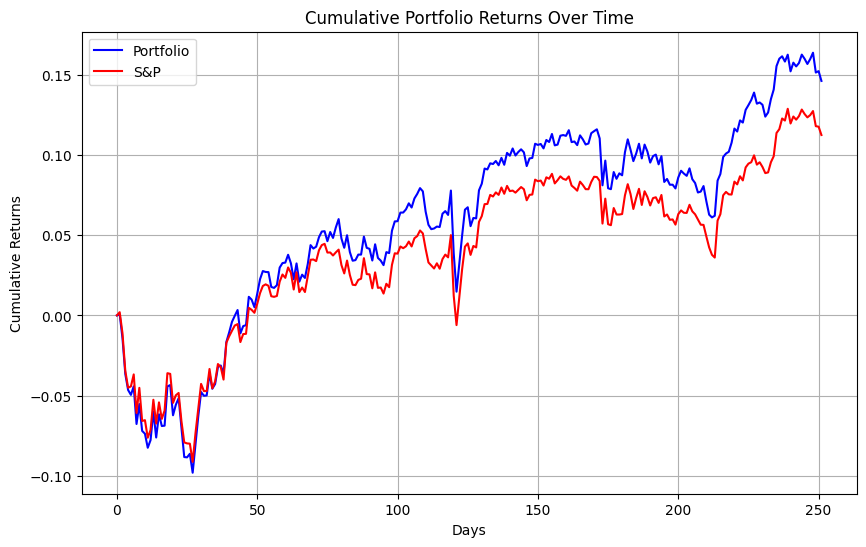

In [143]:
def run_tests(start="2020-01-01", flag="backtest"):
    ticker_returns, index_returns = preparePipeline(start)
    portfolio_weights = track(ticker_returns, index_returns, reg=0.2)

    if flag == "backtest":
        backtest_start = str(int(start[0:4]) + 1) + start[4:] # 252 days later
        print(backtest_start)

        # for future testing
        ticker_returns, index_returns = preparePipeline(backtest_start)

    # print(ticker_returns)
    weights_df = pd.DataFrame(portfolio_weights.numpy())
    returns_df = pd.DataFrame(ticker_returns.numpy())
    index_returns_df = pd.DataFrame(index_returns.numpy())
    # print(returns_df)

    non_zero_weights = weights_df[weights_df > 0]
    # print(non_zero_weights)
    # print(non_zero_weights.index)
    filtered_returns_df = returns_df.loc[:, non_zero_weights.index]
    # print(filtered_returns_df)

    weighted_returns = filtered_returns_df.mul(non_zero_weights.values.flatten(), axis=1)
    # print(weighted_returns)
    daily_portfolio_returns = weighted_returns.sum(axis=1)
    # print(daily_portfolio_returns)

    plt.figure(figsize=(10, 6))
    plt.plot(daily_portfolio_returns, label='Portfolio', color='blue')
    plt.plot(index_returns_df, label="S&P", color='red')
    plt.title('Cumulative Portfolio Returns Over Time')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

run_tests("2015-01-01", flag="backtest")

[*********************100%%**********************]  1 of 1 completed


Number of NaNs in the original matrix: 6777
2019-01-01


[*********************100%%**********************]  1 of 1 completed


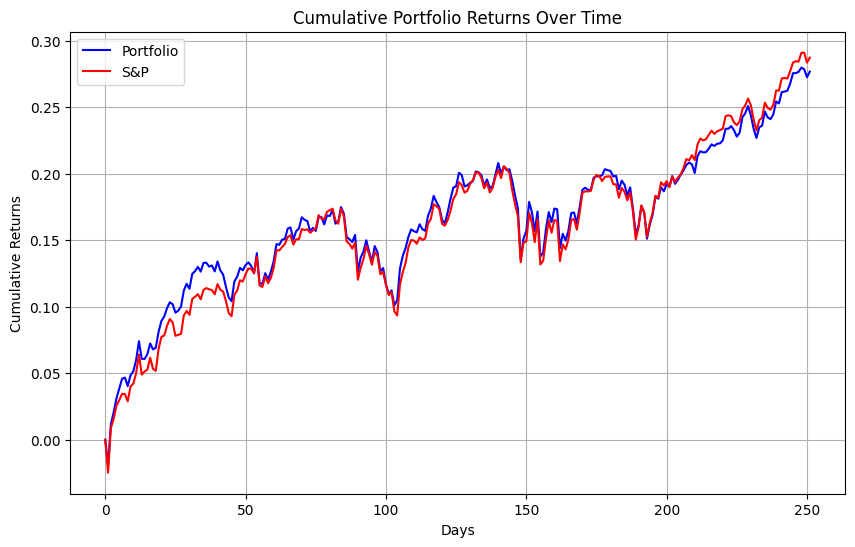

In [147]:
run_tests("2018-01-01")